In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [4]:
# Constants
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 50
DATASET_PATH = "/content/drive/MyDrive/PlantVillage"

In [5]:
# Load dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_PATH,
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2170 files belonging to 3 classes.


In [6]:
# Class names
class_names = dataset.class_names
print("Class Names:", class_names)

Class Names: ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


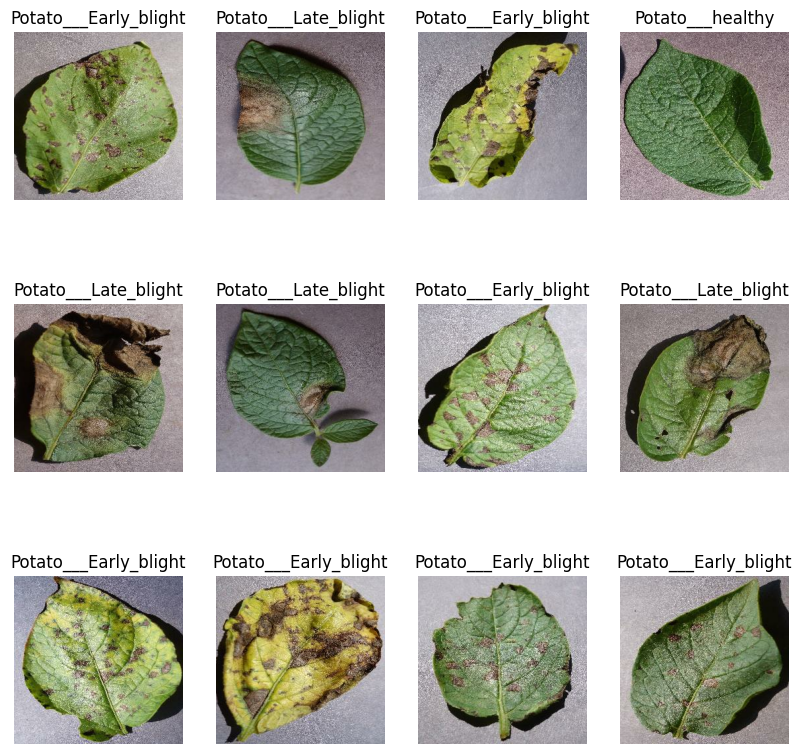

In [7]:
# Visualize some sample images
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")


In [8]:
# Split dataset
train_size = 0.8
val_size = 0.1
test_size = 0.1


In [9]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + val_split + test_split) == 1
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [10]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [11]:
# Optimize performance with caching and prefetching
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


In [12]:
# Data augmentation (including adding heavy noise)
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.Lambda(lambda x: x + tf.random.normal(shape=tf.shape(x), mean=0.0, stddev=0.2, dtype=tf.float32))  # Add more noise
])

In [13]:
# Apply augmentation to the training dataset
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

# Model definition
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255)
])

In [14]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = len(class_names)

In [15]:
model = models.Sequential([
    resize_and_rescale,

    # Add Gaussian noise to the input images
    layers.GaussianNoise(0.2),  # Increased noise

    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),

    # Add Gaussian noise to feature maps after each convolutional block
    layers.GaussianNoise(0.1),

    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.GaussianNoise(0.1),

    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.GaussianNoise(0.1),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.GaussianNoise(0.1),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.GaussianNoise(0.1),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),

    # Add noise to the dense layers
    layers.GaussianNoise(0.1),

    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 gaussian_noise (GaussianNo  (32, 256, 256, 3)         0         
 ise)                                                            
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 gaussian_noise_1 (Gaussian  (32, 127, 127, 32)        0         
 Noise)                                                          
                                                      

In [16]:
# Compile model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


In [17]:
# Train model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)


Epoch 1/50
54/54 [==============================] - 43s 598ms/step - loss: 0.8751 - accuracy: 0.5509 - val_loss: 0.9992 - val_accuracy: 0.4896
Epoch 2/50
54/54 [==============================] - 29s 525ms/step - loss: 0.5406 - accuracy: 0.7894 - val_loss: 0.8691 - val_accuracy: 0.4896
Epoch 3/50
54/54 [==============================] - 29s 521ms/step - loss: 0.4596 - accuracy: 0.8212 - val_loss: 0.8492 - val_accuracy: 0.5052
Epoch 4/50
54/54 [==============================] - 28s 521ms/step - loss: 0.4163 - accuracy: 0.8275 - val_loss: 0.7408 - val_accuracy: 0.5677
Epoch 5/50
54/54 [==============================] - 29s 525ms/step - loss: 0.3546 - accuracy: 0.8571 - val_loss: 0.6005 - val_accuracy: 0.8021
Epoch 6/50
54/54 [==============================] - 28s 519ms/step - loss: 0.3290 - accuracy: 0.8709 - val_loss: 0.6504 - val_accuracy: 0.6562
Epoch 7/50
54/54 [==============================] - 29s 526ms/step - loss: 0.2547 - accuracy: 0.8958 - val_loss: 0.7118 - val_accuracy: 0.6458

In [18]:
# Save the model
model.save('potatoes.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [19]:
# Evaluate the model on the test dataset
scores = model.evaluate(test_ds)
print(f"Test Accuracy: {scores[1]*100:.2f}%")

8/8 [==============================] - 4s 94ms/step - loss: 0.2453 - accuracy: 0.9102
Test Accuracy: 91.02%


In [20]:
# Plotting training results (accuracy and loss)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

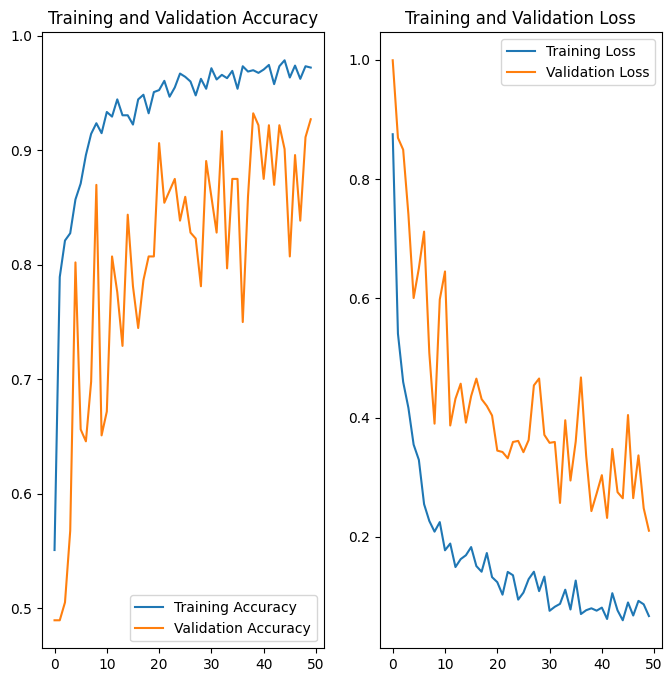

In [21]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [22]:
#dataset link
#https://drive.google.com/drive/folders/1IB30n-VIPByRIccrG9BhkWd7pp0naged?usp=sharing